In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.regularizers as regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dense
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [10]:
df = pd.read_csv('stock_features.csv', parse_dates=True)
df['date'] = pd.to_datetime(df['date'])
target ='close'
features = df.drop(columns=['date', target]).values
X = features.copy()
y = df[target].copy().values.reshape(-1, 1)

In [11]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X)
y_train_scaled = scaler_y.fit_transform(y)


def create_sequneces(X, y, time_steps=24):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X[i:i+time_steps])
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)


In [12]:
"""数据增强"""
def moving_average_smoothing(series, window_size=3):
    smoothed_data = np.empty_like(series)  # 创建一个与原始数据形状相同的空数组
    for col in range(series.shape[1]):
        # 对每一列(每个特征)进行平滑处理
        smoothed_data[:,col] = np.convolve(series[:,col], np.ones(window_size)/window_size, mode='same')
    return smoothed_data

def random_noise(data, noise_factor=0.01):
    """随机噪声"""
    noise = noise_factor + np.random.randn(*data.shape)
    return data + noise

def time_series_shift(series, shift_range=5):
    """时间序列平移"""
    shift = np.random.randint(-shift_range, shift_range + 1)
    return np.roll(series, shift, axis=0)

def data_augmentation(X, y, num_augmentations=5):
    augmented_X, augmented_y = [], []
    for i in range(len(X)):
        # 移动平均平滑
        augmented_X.append(X[i])
        augmented_y.append(y[i])
        for _ in range(num_augmentations):
            # 增强方法1 平滑处理
            X_smooth = moving_average_smoothing(X[i])
            # 增加方法2 添加噪声
            X_noise = random_noise(X_smooth)
            # 增加方法3 时间偏移
            X_shift = time_series_shift(X_noise)
            augmented_X.append(X_shift)
            augmented_y.append(y[i])
    return np.array(augmented_X), np.array(augmented_y)

In [13]:
def plot_history(history, fold =1):
    plt.figure(figsize=(16, 6))
    plt.plot(history.history['loss'], label=f'Fold {fold + 1} - Training Loss', color='blue', linewidth=2)
    # 绘制验证损失曲线（如果有验证集）
    plt.plot(history.history['val_loss'], label=f'Fold {fold + 1} - Validation Loss', color='orange', linewidth=2)

    plt.title(f'Fold {fold + 1} -Model Training History')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

Window Size: 10
划分数据集...
Origin traning data shape: (128976, 10, 39)
Augmented traning data shape: (773856, 10, 39)
交叉验证...
Fold 1:
构建LSTM模型...


c:\Users\liufa\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 10, 64)         │        26,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,713 (233.25 KB)

 Trainable params: 59,713 (233.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
24179/24179 ━━━━━━━━━━━━━━━━━━━━ 250s 10ms/step - loss: 0.0759 - mae: 0.0733 - val_loss: 0.0076 - val_mae: 0.0648
Epoch 2/20
24179/24179 ━━━━━━━━━━━━━━━━━━━━ 233s 10ms/step - loss: 0.0068 - mae: 0.0599 - val_loss: 0.0073 - val_mae: 0.0639
Epoch 3/20
24179/24179 ━━━━━━━━━━━━━━━━━━━━ 236s 10ms/step - loss: 0.0066 - mae: 0.0586 - val_loss: 0.0070 - val_mae: 0.0607
Epoch 4/20
24179/24179 ━━━━━━━━━━━━━━━━━━━━ 268s 11ms/step - loss: 0.0065 - mae: 0.0583 - val_loss: 0.0063 - val_mae: 0.0584
Epoch 5/20
24179/24179 ━━━━━━━━━━━━━━━━━━━━ 357s 15ms/step - loss: 0.0065 - mae: 0.0580 - val_loss: 0.0079 - val_mae: 0.0666
Epoch 6/20
24179/24179 ━━━━━━━━━━━━━━━━━━━━ 291s 12ms/step - loss: 0.0064 - mae: 0.0579 - val_loss: 0.0057 - val_mae: 0.0516
Epoch 7/20
24179/24179 ━━━━━━━━━━━━━━━━━━━━ 297s 12ms/step - loss: 0.0064 - mae: 0.0578 - val_loss: 0.0076 - val_mae: 0.0603
Epoch 8/20
24179/24179 ━━━━━━━━━━━━━━━━━━━━ 235s 10ms/step - loss: 0.0064 - mae: 0.0576 - val_loss: 0.0069 - val_mae: 0.0595


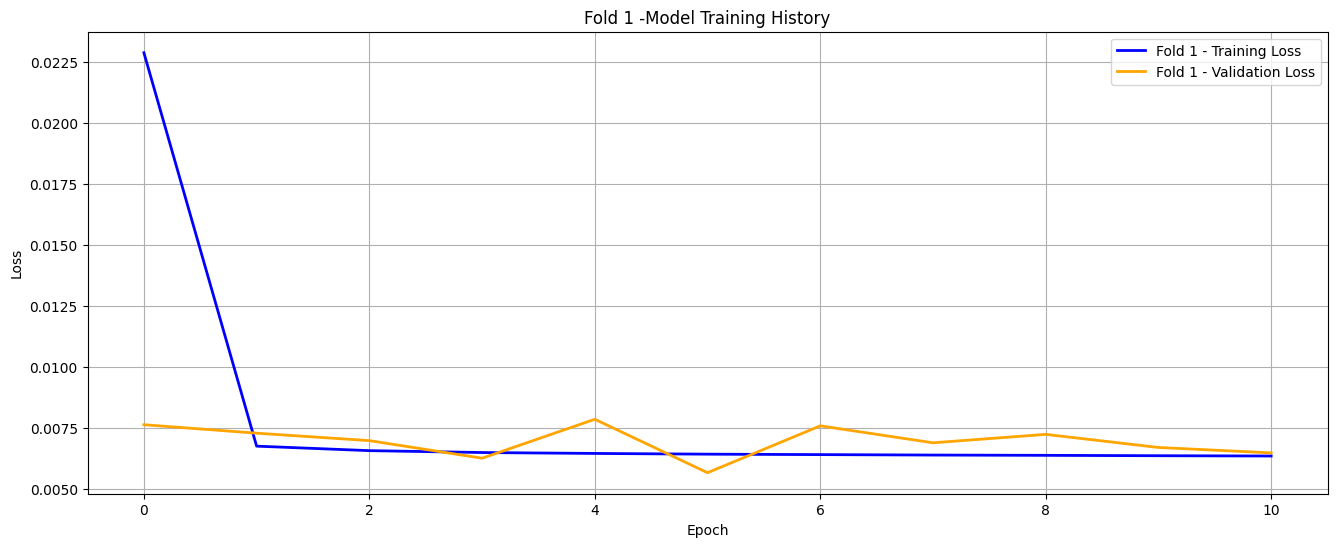

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
Fold 2:
构建LSTM模型...


c:\Users\liufa\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 10, 64)         │        26,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,713 (233.25 KB)

 Trainable params: 59,713 (233.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
24180/24180 ━━━━━━━━━━━━━━━━━━━━ 266s 11ms/step - loss: 0.0766 - mae: 0.0730 - val_loss: 0.0053 - val_mae: 0.0606
Epoch 2/20
24180/24180 ━━━━━━━━━━━━━━━━━━━━ 280s 12ms/step - loss: 0.0068 - mae: 0.0596 - val_loss: 0.0045 - val_mae: 0.0527
Epoch 3/20
24180/24180 ━━━━━━━━━━━━━━━━━━━━ 239s 10ms/step - loss: 0.0066 - mae: 0.0583 - val_loss: 0.0039 - val_mae: 0.0435
Epoch 4/20
24180/24180 ━━━━━━━━━━━━━━━━━━━━ 222s 9ms/step - loss: 0.0065 - mae: 0.0580 - val_loss: 0.0037 - val_mae: 0.0483
Epoch 5/20
24180/24180 ━━━━━━━━━━━━━━━━━━━━ 263s 11ms/step - loss: 0.0064 - mae: 0.0578 - val_loss: 0.0038 - val_mae: 0.0494
Epoch 6/20
24180/24180 ━━━━━━━━━━━━━━━━━━━━ 287s 12ms/step - loss: 0.0064 - mae: 0.0578 - val_loss: 0.0028 - val_mae: 0.0379
Epoch 7/20
24180/24180 ━━━━━━━━━━━━━━━━━━━━ 325s 13ms/step - loss: 0.0064 - mae: 0.0576 - val_loss: 0.0037 - val_mae: 0.0516
Epoch 8/20
24180/24180 ━━━━━━━━━━━━━━━━━━━━ 312s 13ms/step - loss: 0.0064 - mae: 0.0575 - val_loss: 0.0034 - val_mae: 0.0454
E

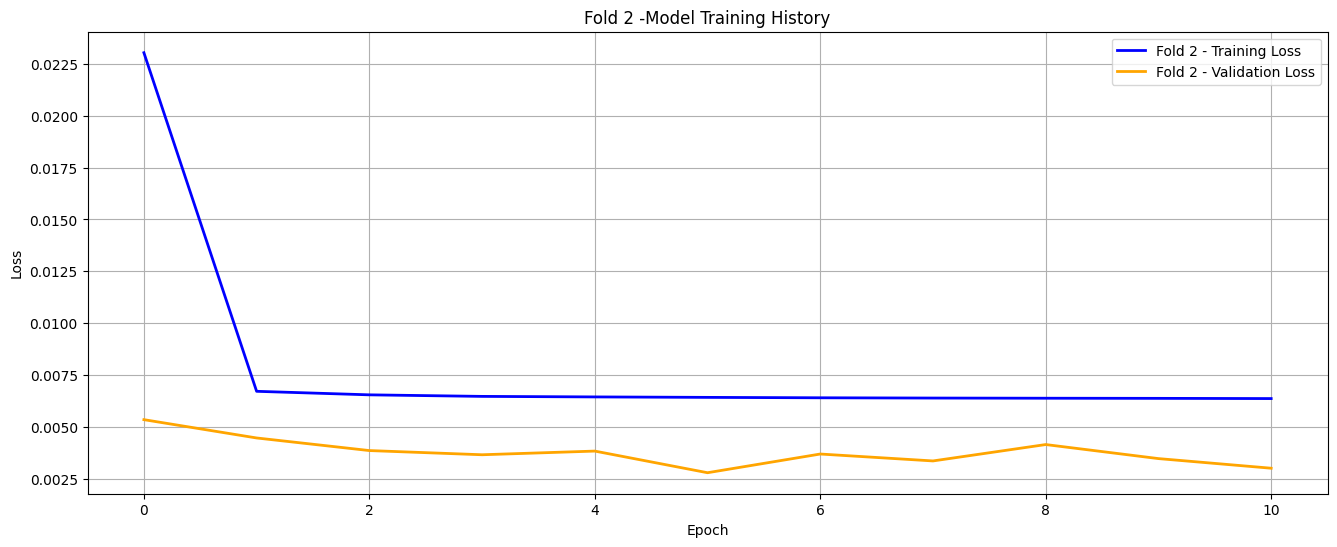

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
Fold 3:
构建LSTM模型...


c:\Users\liufa\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 10, 64)         │        26,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,713 (233.25 KB)

 Trainable params: 59,713 (233.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
24181/24181 ━━━━━━━━━━━━━━━━━━━━ 329s 13ms/step - loss: 0.0723 - mae: 0.0716 - val_loss: 0.0066 - val_mae: 0.0660
Epoch 2/20
24181/24181 ━━━━━━━━━━━━━━━━━━━━ 324s 13ms/step - loss: 0.0068 - mae: 0.0597 - val_loss: 0.0063 - val_mae: 0.0627
Epoch 3/20
24181/24181 ━━━━━━━━━━━━━━━━━━━━ 297s 12ms/step - loss: 0.0066 - mae: 0.0586 - val_loss: 0.0072 - val_mae: 0.0709
Epoch 4/20
24181/24181 ━━━━━━━━━━━━━━━━━━━━ 301s 12ms/step - loss: 0.0065 - mae: 0.0582 - val_loss: 0.0066 - val_mae: 0.0664
Epoch 5/20
24181/24181 ━━━━━━━━━━━━━━━━━━━━ 322s 13ms/step - loss: 0.0065 - mae: 0.0580 - val_loss: 0.0055 - val_mae: 0.0588
Epoch 6/20
24181/24181 ━━━━━━━━━━━━━━━━━━━━ 356s 15ms/step - loss: 0.0065 - mae: 0.0579 - val_loss: 0.0044 - val_mae: 0.0507
Epoch 7/20
24181/24181 ━━━━━━━━━━━━━━━━━━━━ 327s 14ms/step - loss: 0.0064 - mae: 0.0577 - val_loss: 0.0046 - val_mae: 0.0533
Epoch 8/20
24181/24181 ━━━━━━━━━━━━━━━━━━━━ 324s 13ms/step - loss: 0.0064 - mae: 0.0576 - val_loss: 0.0050 - val_mae: 0.0567


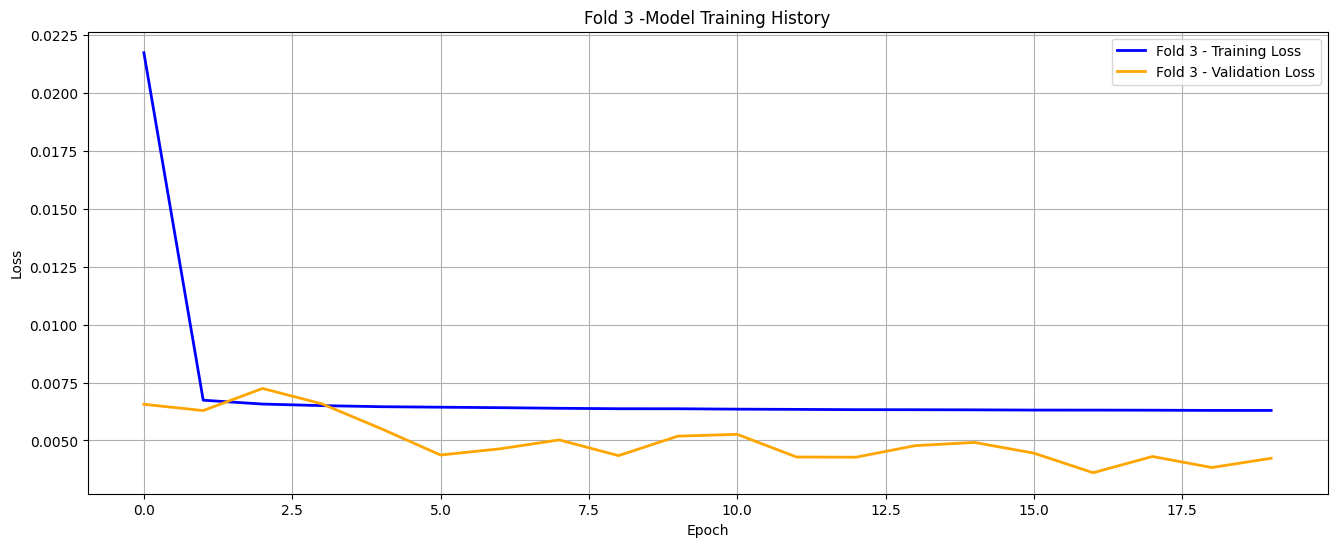

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 617ms/step
Fold 4:
构建LSTM模型...


c:\Users\liufa\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 10, 64)         │        26,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,713 (233.25 KB)

 Trainable params: 59,713 (233.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
24182/24182 ━━━━━━━━━━━━━━━━━━━━ 310s 13ms/step - loss: 0.0751 - mae: 0.0735 - val_loss: 0.0096 - val_mae: 0.0769
Epoch 2/20
24182/24182 ━━━━━━━━━━━━━━━━━━━━ 288s 12ms/step - loss: 0.0068 - mae: 0.0599 - val_loss: 0.0097 - val_mae: 0.0810
Epoch 3/20
24182/24182 ━━━━━━━━━━━━━━━━━━━━ 289s 12ms/step - loss: 0.0066 - mae: 0.0586 - val_loss: 0.0089 - val_mae: 0.0767
Epoch 4/20
24182/24182 ━━━━━━━━━━━━━━━━━━━━ 283s 12ms/step - loss: 0.0065 - mae: 0.0582 - val_loss: 0.0092 - val_mae: 0.0690
Epoch 5/20
24182/24182 ━━━━━━━━━━━━━━━━━━━━ 287s 12ms/step - loss: 0.0065 - mae: 0.0581 - val_loss: 0.0073 - val_mae: 0.0671
Epoch 6/20
24182/24182 ━━━━━━━━━━━━━━━━━━━━ 289s 12ms/step - loss: 0.0065 - mae: 0.0580 - val_loss: 0.0081 - val_mae: 0.0716
Epoch 7/20
24182/24182 ━━━━━━━━━━━━━━━━━━━━ 293s 12ms/step - loss: 0.0064 - mae: 0.0578 - val_loss: 0.0078 - val_mae: 0.0695
Epoch 8/20
24182/24182 ━━━━━━━━━━━━━━━━━━━━ 291s 12ms/step - loss: 0.0064 - mae: 0.0577 - val_loss: 0.0063 - val_mae: 0.0585


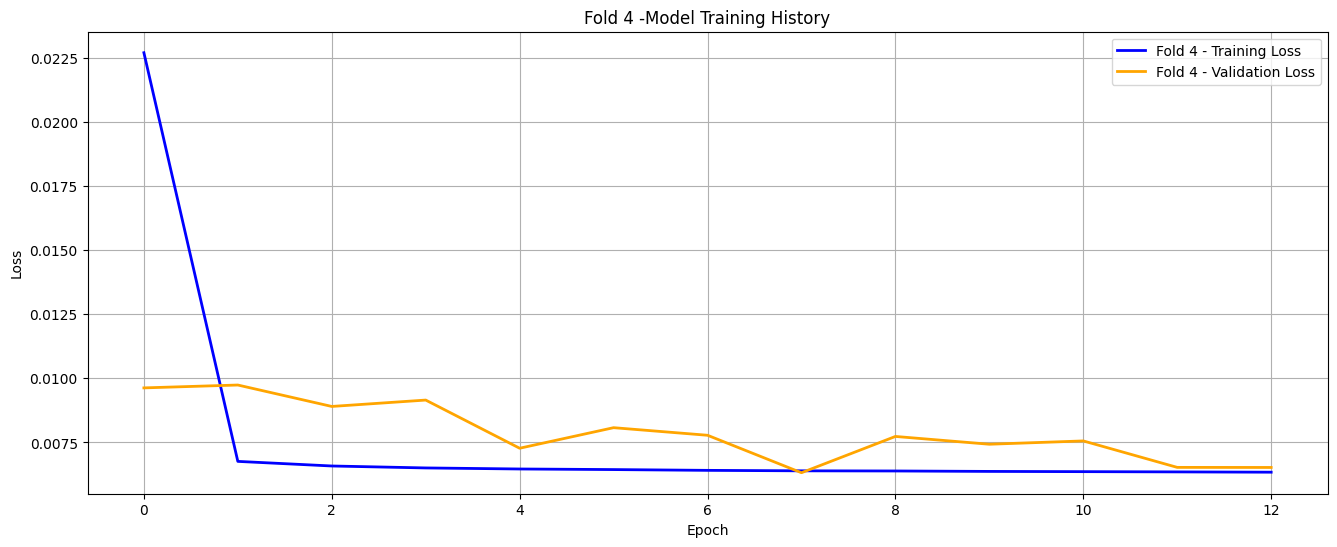

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step
Fold 5:
构建LSTM模型...


c:\Users\liufa\.pyenv\pyenv-win\versions\3.9.13\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 10, 64)         │        26,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,713 (233.25 KB)

 Trainable params: 59,713 (233.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20


In [ ]:
window_sizes = [10, 30, 60, 90, 120]
metrics = ['MSE', 'RMSE', 'MAE', 'R2']

results = {window_size: {metric: [] for metric in metrics} for window_size in window_sizes}

def train_windows(X, y, window_size=24, stride=1):
    """
    将时间序列数据划分为多个窗口，每个窗口包含过去window_size个时间步的数据和下一个时间步的标签。
    """
    X_train, y_train = create_sequneces(X_train_scaled, y_train_scaled, window_size)
    print("划分数据集...")

    X_train_full_augmented, y_train_full_augmented = data_augmentation(X_train, y_train)

    print(f"Origin traning data shape: {X_train.shape}")
    print(f"Augmented traning data shape: {X_train_full_augmented.shape}")

    print("交叉验证...")
    tscv = TimeSeriesSplit(n_splits=5, test_size=30)
    result = {metric: [] for metric in metrics}
    for fold,(train_index, val_index) in enumerate(tscv.split(X_train_full_augmented)):
        print(f"Fold {fold + 1}:")
        X_train_fold, X_val_fold = X_train_full_augmented[train_index], X_train_full_augmented[val_index]
        y_train_fold, y_val_fold = y_train_full_augmented[train_index], y_train_full_augmented[val_index]

        print("构建LSTM模型...")
        model = Sequential([
            LSTM(units=64, 
                input_shape=(X_train.shape[1], X_train.shape[2]), 
                return_sequences=True,
                kernel_regularizer=regularizers.l2(0.01)),
            Dropout(0.2),
            LSTM(units=64, return_sequences=False),
            Dropout(0.2),
            Dense(units=1)])

        model.compile(optimizer=Adam(learning_rate= 0.0001), loss='mean_squared_error', metrics=['mae'])
        
        model.summary()
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        history = model.fit(X_train_fold, y_train_fold, epochs=20, batch_size=32, validation_data=(X_val_fold, y_val_fold), verbose=1, callbacks=[early_stopping])
        plot_history(history=history, fold=fold)

        val_predictions = model.predict(X_val_fold)
        val_predictions_prices = scaler_y.inverse_transform(val_predictions)
        val_real_prices = scaler_y.inverse_transform(y_val_fold.reshape(-1, 1))

        mse = mean_squared_error(val_real_prices, val_predictions_prices)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(val_real_prices, val_predictions_prices)
        r2 = r2_score(val_real_prices, val_predictions)
        result['MSE'].append(mse)
        result['RMSE'].append(rmse)
        result['MAE'].append(mae)
        result['R2'].append(r2)
        print(f"Fold {fold + 1} for window_{window_size} - MSE: {mse}, RMSE: {rmse}, MAE: {mae}, R2: {r2}")
    return result

for window_size in window_sizes:
    print(f"Window Size: {window_size}")
    result = train_windows(X, y, window_size=window_size)
    results[window_size] = result

averages = {window_size: {metric: np.mean(result[metric]) for metric in result} for window_size, result in results.items()}

# 对指标进行对数变换，仅对MSE、RMSE进行操作
log_transformed_averages = {window_size: {
    "MSE": np.log(averages[window_size]["MSE"]),
    "RMSE": np.log(averages[window_size]["RMSE"]),
    "MAE": averages[window_size]["MAE"],
    "R2": averages[window_size]["R2"] 
    } for window_size in results.items()}

colors = sns.color_palette("Blues", len(window_sizes))
r = np.arange(len(metrics))
plt.figure(figsize=(10, 6))
barWidth = 0.15 # 每个柱子的宽度
for i, (window_size, result) in enumerate(results.items()):
    avg_metrics =[log_transformed_averages[metric] for metric in metrics]
    bars = plt.bar(r + i * barWidth, avg_metrics, width=barWidth, colors=colors[i], edgecolor='white', label=f'Window Size {window_size}')
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom', ha='center')
plt.xlabel("Metrics", fontweight='bold')
plt.ylabel("log-transformed / Original Value", fontweight='bold')
plt.xticks([r + barWidth * (len(window_sizes) /2 -0.5) for r in np.arange(len(metrics))], metrics)

plt.title("Log-Transformed Evaluation Metrics for Different Window Sizes", fontweight='bold')

plt.legend()
plt.tight_layout()
plt.show()


